In [4]:
from a72_utilities import *
import pandas as pd

This workbook is for looking at the average spectra for the five different phases we've identified for each element

In [5]:
xas_data, old_masks, xas_energies = load_registered_xas()
aligned_masks = load_phase_masks()

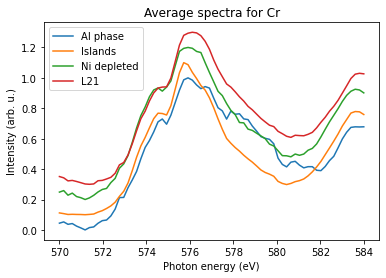

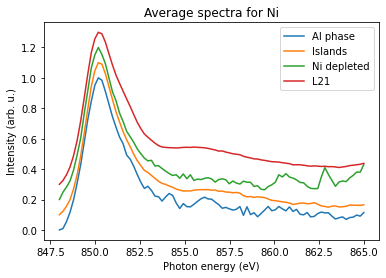

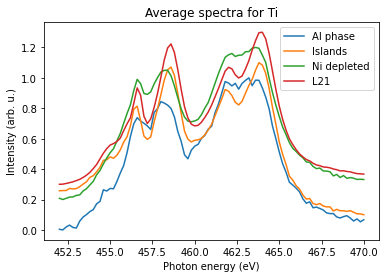

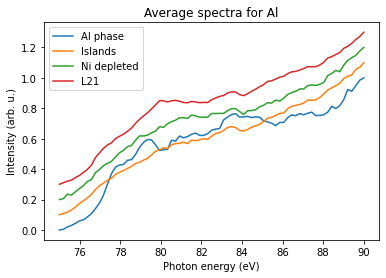

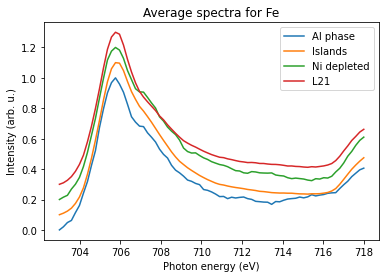

In [13]:
#plot average spectra of the matrix and l12 phases for all of the elements

average_spectra = pd.DataFrame(index=range(200))

for i, (element, xas) in enumerate(xas_data.items()):
    phaselist = []
    for j, (phase,mask) in enumerate(aligned_masks.items()):
        phaselist.append(phase)
        segmented = mask_subtract_arr(trim_edges(xas,border=30), mask)
        segmented = segmented.astype(float)
        segmented[segmented == 0.] = np.nan

        average_spectra['energy_'+element+"_"+phase] = pd.Series(xas_energies[element])
        average_spectra['intensity_'+element+"_"+phase] = pd.Series(np.nanmean(segmented,axis=(1,2)))
        
        #plt.plot(xas_energies[element],0.1*j+normalize_array(np.nanmean(segmented,axis=(1,2))))
        plt.plot(xas_energies[element],0.1*j+normalize_array(np.nanmean(segmented,axis=(1,2))))

    
    plt.xlabel("Photon energy (eV)")
    plt.legend(phaselist)
    plt.ylabel("Intensity (arb. u.)")
    plt.title("Average spectra for "+ element)
    plt.show()

In [10]:
average_spectra.head()

,energy_Cr_Al phase,intensity_Cr_Al phase,energy_Cr_Islands,intensity_Cr_Islands,energy_Cr_Ni depleted,intensity_Cr_Ni depleted,energy_Cr_L21,intensity_Cr_L21,energy_Ni_Al phase,intensity_Ni_Al phase,...,energy_Al_L21,intensity_Al_L21,energy_Fe_Al phase,intensity_Fe_Al phase,energy_Fe_Islands,intensity_Fe_Islands,energy_Fe_Ni depleted,intensity_Fe_Ni depleted,energy_Fe_L21,intensity_Fe_L21
0,570.000000,950.112121,570.000000,892.308362,570.000000,296.812538,570.000000,1038.952464,848.000000,1249.369697,...,75.000000,3816.499294,703.000000,691.787879,703.000000,656.735649,703.000000,204.947657,703.000000,672.525197
1,570.197183,956.651515,570.197183,888.466968,570.197183,298.648813,570.197183,1036.063364,848.197674,1253.724242,...,75.197368,3832.954221,703.197368,713.169697,703.197368,673.865497,703.197368,209.756543,703.197368,682.037443
2,570.394366,944.106061,570.394366,883.903860,570.394366,293.046257,570.394366,1029.208750,848.395349,1275.751515,...,75.394737,3850.270004,703.394737,742.236364,703.394737,696.920108,703.394737,213.596470,703.394737,698.156350
3,570.591549,948.039394,570.591549,884.764503,570.591549,295.577602,570.591549,1030.244605,848.593023,1305.524242,...,75.592105,3860.502773,703.592105,756.766667,703.592105,729.829648,703.592105,226.431528,703.592105,721.295512
4,570.788732,934.690909,570.788732,883.991852,570.788732,291.391357,570.788732,1027.851725,848.790698,1345.263636,...,75.789474,3887.742896,703.789474,810.015152,703.789474,782.255785,703.789474,236.426659,703.789474,754.625659
